In [1]:
import os
os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import itertools
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from scripts.data_preparation import merge_station_data 
from scripts.metrics import macro_averaged_mean_squared_error
from scripts.models.frank_model import (
    OrdinalClassifier,
    prepare_data,
    fit_and_predict
)

# Other settings
plt.rcParams["figure.figsize"] = [12,6]

## Get data

In [4]:
# Get data
df = merge_station_data()

test_split = '2015-01-01'
val_split  = '2010-01-01'

mask = df.date < test_split
df_train_val = df[mask]

['Processed data for station: KLO3']
['Processed data for station: ANV3']
['Processed data for station: GAN2']
['Processed data for station: DAV3']


## Round 1: Choose classifiers

In [5]:
def cv_choose_classifier(df, classifiers, val_split, nruns, nclass=4, mixed=True):
    """Perform cross validation to choose classifiers."""
    
    scores = dict()
    for PCA in [True, False]:
        for drop_cat in [True, False]:
            # Whether to try mixing different classifiers
            if mixed:
                combs = itertools.product(classifiers, repeat=nclass-1)
            else:
                combs = ( (c,)*(nclass-1) for c in classifiers )
            
            for clf in combs:
                mamses = []
                print(f'PCA={PCA}, drop_cat={drop_cat}, {str(clf)}:')
                for i in range(nruns):
                    y_pred, y_true, _ = fit_and_predict(
                                            df, 
                                            test_split=val_split,
                                            verbose=False,
                                            classifier=clf,
                                            PCA=PCA,
                                            drop_cat=drop_cat)
                    err = macro_averaged_mean_squared_error(
                                y_pred=y_pred,
                                y_true=y_true)
                    mamses.append(err)
                    print(f'  [{i+1}] {err}')
                    if i == 1 and (abs(mamses[-1] - mamses[-2]) <= 1e-13):
                        # Runs are deterministic, skip next runs
                        break
                mamse = np.mean(mamses)
                mamse_std = np.std(mamses)
                scores[mamse] = {
                    'classifier': clf,
                    'PCA': PCA,
                    'drop_cat': drop_cat
                }
                print(f'  MEAN: {mamse} | STD: {mamse_std}\n')
        
    min_mamse = min(list(scores.keys()))
    best_clfs = scores[min_mamse]
    print(f'BEST CLASSIFIERS: {best_clfs}')

    return min_mamse, best_clfs

In [6]:
# Suppress XGB warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

nruns = 5
nclass = 4
classifiers = ['logistic', 'tree', 'xgb', 'forest', 'svm']

mamse, best_params_s1 = cv_choose_classifier(df_train_val, classifiers, val_split, nruns)

PCA=True, drop_cat=True, ('logistic', 'logistic', 'logistic'):
  [1] 0.3427140634472951
  [2] 0.3427140634472951
  MEAN: 0.3427140634472951 | STD: 0.0

PCA=True, drop_cat=True, ('logistic', 'logistic', 'tree'):
  [1] 0.30107963957150236
  [2] 0.29272400775914875
  [3] 0.3298708639516671
  [4] 0.30352815013457135
  [5] 0.23265189308281764
  MEAN: 0.2919709108999414 | STD: 0.03216289224472573

PCA=True, drop_cat=True, ('logistic', 'logistic', 'xgb'):
  [1] 0.4064073808697295
  [2] 0.4064073808697295
  MEAN: 0.4064073808697295 | STD: 0.0

PCA=True, drop_cat=True, ('logistic', 'logistic', 'forest'):
  [1] 0.40550208018320366
  [2] 0.40430876276076927
  [3] 0.3424054214719865
  [4] 0.40550208018320366
  [5] 0.4049054214719865
  MEAN: 0.3925247532142299 | STD: 0.025063572260593293

PCA=True, drop_cat=True, ('logistic', 'logistic', 'svm'):
  [1] 0.40760069829216383
  [2] 0.40760069829216383
  MEAN: 0.40760069829216383 | STD: 0.0

PCA=True, drop_cat=True, ('logistic', 'tree', 'logistic'):
  [1

  [1] 0.5818323934897612
  [2] 0.52192026588802
  [3] 0.5727531806675358
  [4] 0.596241020849834
  [5] 0.5802230296700996
  MEAN: 0.5705939781130501 | STD: 0.02549738744517398

PCA=True, drop_cat=True, ('tree', 'xgb', 'svm'):
  [1] 0.5753659565301128
  [2] 0.573927175343219
  [3] 0.5821034973342317
  [4] 0.5817287014158046
  [5] 0.594932679179572
  MEAN: 0.581611601960588 | STD: 0.007426510228850485

PCA=True, drop_cat=True, ('tree', 'forest', 'logistic'):
  [1] 0.5341656236968976
  [2] 0.5630564570560856
  [3] 0.5526847080923722
  [4] 0.5464174695777719
  [5] 0.549247093392528
  MEAN: 0.5491142703631311 | STD: 0.009358258480556457

PCA=True, drop_cat=True, ('tree', 'forest', 'tree'):
  [1] 0.5477508854510889
  [2] 0.5120148556360077
  [3] 0.5130381563026303
  [4] 0.4495955126152511
  [5] 0.508314864280266
  MEAN: 0.5061428548570488 | STD: 0.031671985490757115

PCA=True, drop_cat=True, ('tree', 'forest', 'xgb'):
  [1] 0.6187401276423283
  [2] 0.6119020656265067
  [3] 0.649066029840448


  [5] 0.44516637660594416
  MEAN: 0.43534346194545764 | STD: 0.032361914444263666

PCA=True, drop_cat=True, ('forest', 'logistic', 'xgb'):
  [1] 0.5359526411721536
  [2] 0.5273595361682208
  [3] 0.5443238833832964
  [4] 0.5423040538839745
  [5] 0.5365569197092797
  MEAN: 0.537299406863385 | STD: 0.005925468025686322

PCA=True, drop_cat=True, ('forest', 'logistic', 'forest'):
  [1] 0.5366048582683112
  [2] 0.5337003533218636
  [3] 0.5347799489891194
  [4] 0.5400723912730846
  [5] 0.5334342643180041
  MEAN: 0.5357183632340765 | STD: 0.002445956940321

PCA=True, drop_cat=True, ('forest', 'logistic', 'svm'):
  [1] 0.5303259168328687
  [2] 0.5354697042161151
  [3] 0.5407864840874425
  [4] 0.5400324432869335
  [5] 0.5372390551103665
  MEAN: 0.5367707207067453 | STD: 0.0037473368600941053

PCA=True, drop_cat=True, ('forest', 'tree', 'logistic'):
  [1] 0.6229205070686813
  [2] 0.6337582800969952
  [3] 0.8239509519318746
  [4] 0.6350896568619703
  [5] 0.8369906643961342
  MEAN: 0.71054201207113

  [1] 0.4342405462937108
  [2] 0.4343529655562405
  [3] 0.3718529655562405
  [4] 0.4343529655562405
  [5] 0.37244962426745765
  MEAN: 0.409449813445978 | STD: 0.0304547250050686

PCA=True, drop_cat=True, ('svm', 'xgb', 'svm'):
  [1] 0.43764490108763504
  [2] 0.4373362591123264
  [3] 0.43702761713701777
  [4] 0.4373362591123264
  [5] 0.43702761713701777
  MEAN: 0.43727453071726463 | STD: 0.00023096650535641005

PCA=True, drop_cat=True, ('svm', 'forest', 'logistic'):
  [1] 0.4282475263859644
  [2] 0.4200542915035136
  [3] 0.4238291639909467
  [4] 0.4160625710639014
  [5] 0.4220391878572952
  MEAN: 0.4220465481603243 | STD: 0.0040350210112372374

PCA=True, drop_cat=True, ('svm', 'forest', 'tree'):
  [1] 0.3247671635846861
  [2] 0.43501645872639827
  [3] 0.37134674227563325
  [4] 0.4593341330735763
  [5] 0.3127154478945377
  MEAN: 0.3806359891109663 | STD: 0.058260533863569886

PCA=True, drop_cat=True, ('svm', 'forest', 'xgb'):
  [1] 0.4833577684856879
  [2] 0.49145232613479306
  [3] 0.478

  [1] 0.49409619839958285
  [2] 0.49817971286232465
  [3] 0.48911370058357523
  [4] 0.4973026572411079
  [5] 0.4924392667678611
  MEAN: 0.49422630717089033 | STD: 0.003299773753658899

PCA=True, drop_cat=False, ('tree', 'logistic', 'tree'):
  [1] 0.4970133380125504
  [2] 0.4891975040338246
  [3] 0.5036178343147396
  [4] 0.5067458752935974
  [5] 0.501799613115779
  MEAN: 0.4996748329540982 | STD: 0.006114238576633535

PCA=True, drop_cat=False, ('tree', 'logistic', 'xgb'):
  [1] 0.549323874602447
  [2] 0.5512119620924881
  [3] 0.5470652694188971
  [4] 0.5621067911283762
  [5] 0.5559789144489655
  MEAN: 0.5531373623382347 | STD: 0.005359948478442915

PCA=True, drop_cat=False, ('tree', 'logistic', 'forest'):
  [1] 0.5484148615679592
  [2] 0.5529787080014417
  [3] 0.554735053482202
  [4] 0.5589322897001223
  [5] 0.5491638875278573
  MEAN: 0.5528449600559165 | STD: 0.0038424469141441894

PCA=True, drop_cat=False, ('tree', 'logistic', 'svm'):
  [1] 0.5635868227940701
  [2] 0.5576977217988878


  [1] 0.5015298922550763
  [2] 0.5015298922550763
  MEAN: 0.5015298922550763 | STD: 0.0

PCA=True, drop_cat=False, ('xgb', 'xgb', 'forest'):
  [1] 0.5018179089909848
  [2] 0.5015298922550763
  [3] 0.500912608304459
  [4] 0.5018179089909848
  [5] 0.5018179089909848
  MEAN: 0.5015792455064979 | STD: 0.0003514887420815411

PCA=True, drop_cat=False, ('xgb', 'xgb', 'svm'):
  [1] 0.5048012025470707
  [2] 0.5048012025470707
  MEAN: 0.5048012025470707 | STD: 0.0

PCA=True, drop_cat=False, ('xgb', 'forest', 'logistic'):
  [1] 0.4606634707302096
  [2] 0.4595063889459644
  [3] 0.46688685378071176
  [4] 0.4661495307416559
  [5] 0.4591202608536664
  MEAN: 0.46246530101044164 | STD: 0.0033560311150868443

PCA=True, drop_cat=False, ('xgb', 'forest', 'tree'):
  [1] 0.4555622363184123
  [2] 0.4618062446083146
  [3] 0.45902846683053683
  [4] 0.4642278125987236
  [5] 0.4720798822156385
  MEAN: 0.46254092851432516 | STD: 0.005575240047157136

PCA=True, drop_cat=False, ('xgb', 'forest', 'xgb'):
  [1] 0.518

  [1] 0.5465607559647822
  [2] 0.5400569760042804
  [3] 0.5438511712384646
  [4] 0.5458892161218735
  [5] 0.5544747012998974
  MEAN: 0.5461665641258596 | STD: 0.00473171350912454

PCA=True, drop_cat=False, ('forest', 'svm', 'svm'):
  [1] 0.5523012020592457
  [2] 0.5473679452949185
  [3] 0.5435800673939941
  [4] 0.5441780285978604
  [5] 0.5448508709334179
  MEAN: 0.5464556228558873 | STD: 0.003194827444692014

PCA=True, drop_cat=False, ('svm', 'logistic', 'logistic'):
  [1] 0.349632216565404
  [2] 0.349632216565404
  MEAN: 0.349632216565404 | STD: 0.0

PCA=True, drop_cat=False, ('svm', 'logistic', 'tree'):
  [1] 0.35755378172642815
  [2] 0.36170716248025037
  [3] 0.3601433273643071
  [4] 0.3529860278149988
  [5] 0.3623038211914676
  MEAN: 0.3589388241154904 | STD: 0.0033997604890401417

PCA=True, drop_cat=False, ('svm', 'logistic', 'xgb'):
  [1] 0.4124408585407126
  [2] 0.4124408585407126
  MEAN: 0.4124408585407126 | STD: 0.0

PCA=True, drop_cat=False, ('svm', 'logistic', 'forest'):
  [

  [1] 0.24205776813445393
  [2] 0.28782587927034653
  [3] 0.2302435256358847
  [4] 0.286591311369112
  [5] 0.2971074370086261
  MEAN: 0.2687651842836846 | STD: 0.02713510070779404

PCA=False, drop_cat=True, ('logistic', 'xgb', 'xgb'):
  [1] 0.4068180416793745
  [2] 0.4068180416793745
  MEAN: 0.4068180416793745 | STD: 0.0

PCA=False, drop_cat=True, ('logistic', 'xgb', 'forest'):
  [1] 0.40562472425694013
  [2] 0.40622138296815735
  [3] 0.40562472425694013
  [4] 0.40562472425694013
  [5] 0.40562472425694013
  MEAN: 0.40574405599918356 | STD: 0.0002386634844868896

PCA=False, drop_cat=True, ('logistic', 'xgb', 'svm'):
  [1] 0.408608017813026
  [2] 0.408608017813026
  MEAN: 0.408608017813026 | STD: 0.0

PCA=False, drop_cat=True, ('logistic', 'forest', 'logistic'):
  [1] 0.35104053796166046
  [2] 0.35504786880006184
  [3] 0.35585505813019813
  [4] 0.3529130150529124
  [5] 0.354702991186564
  MEAN: 0.35391189422627933 | STD: 0.001728271100938578

PCA=False, drop_cat=True, ('logistic', 'fores

  [1] 0.4218799934982689
  [2] 0.42755856387453217
  [3] 0.42138274863609015
  [4] 0.4244216005771164
  [5] 0.42543801803352294
  MEAN: 0.42413618492390615 | STD: 0.002287388045883824

PCA=False, drop_cat=True, ('tree', 'svm', 'forest'):
  [1] 0.4216218950672896
  [2] 0.42100591360932127
  [3] 0.42218863547357754
  [4] 0.4213764313028302
  [5] 0.4237049027774607
  MEAN: 0.42197955564609585 | STD: 0.0009444782662205522

PCA=False, drop_cat=True, ('tree', 'svm', 'svm'):
  [1] 0.42774846925405124
  [2] 0.4181852121131231
  [3] 0.42247163736887505
  [4] 0.424709617313025
  [5] 0.41744658658141826
  MEAN: 0.4221123045260985 | STD: 0.003894418708999035

PCA=False, drop_cat=True, ('xgb', 'logistic', 'logistic'):
  [1] 0.33391433530239
  [2] 0.33391433530239
  MEAN: 0.33391433530239 | STD: 0.0

PCA=False, drop_cat=True, ('xgb', 'logistic', 'tree'):
  [1] 0.21401687220683624
  [2] 0.2777514401080708
  [3] 0.21615674079459662
  [4] 0.22177584530797267
  [5] 0.21739130869583118
  MEAN: 0.22941844

  [4] 0.49970368048323555
  [5] 0.4941438467027618
  MEAN: 0.5012094654043318 | STD: 0.006020730886486148

PCA=False, drop_cat=True, ('forest', 'xgb', 'logistic'):
  [1] 0.38258481227227115
  [2] 0.37136091115165915
  [3] 0.38397435240748445
  [4] 0.38281727062323934
  [5] 0.37089729694237167
  MEAN: 0.37832692867940515 | STD: 0.00589764302365321

PCA=False, drop_cat=True, ('forest', 'xgb', 'tree'):
  [1] 0.24420933964305652
  [2] 0.3289698414900594
  [3] 0.3259596053613134
  [4] 0.31611762455000586
  [5] 0.25645727804598395
  MEAN: 0.29434273781808384 | STD: 0.036390861459611346

PCA=False, drop_cat=True, ('forest', 'xgb', 'xgb'):
  [1] 0.4250829156088182
  [2] 0.42785437605333604
  [3] 0.4378256890186113
  [4] 0.439829908119144
  [5] 0.42128872037463394
  MEAN: 0.43037632183490865 | STD: 0.007236411063109956

PCA=False, drop_cat=True, ('forest', 'xgb', 'forest'):
  [1] 0.4348217702231253
  [2] 0.4344768926096274
  [3] 0.4349185790868658
  [4] 0.42993106643024714
  [5] 0.4432742108992

  [1] 0.29522994507676315
  [2] 0.22620553987686126
  [3] 0.22504845809261612
  [4] 0.22770749927460426
  [5] 0.22753821913448535
  MEAN: 0.24034593229106607 | STD: 0.027459008646902552

PCA=False, drop_cat=True, ('svm', 'svm', 'xgb'):
  [1] 0.40565594505451835
  [2] 0.40505928634330113
  [3] 0.40584585043403737
  [4] 0.4058664756734375
  [5] 0.4059439617904269
  MEAN: 0.40567430385914427 | STD: 0.0003217630258345703

PCA=False, drop_cat=True, ('svm', 'svm', 'forest'):
  [1] 0.40567657029391846
  [2] 0.40511614722089045
  [3] 0.40484875572438206
  [4] 0.4067924015993634
  [5] 0.4058871009128376
  MEAN: 0.4056641951502784 | STD: 0.0006764595930477736

PCA=False, drop_cat=True, ('svm', 'svm', 'svm'):
  [1] 0.4073684350711805
  [2] 0.40713727921286125
  [3] 0.40796509378239765
  [4] 0.4079444685429976
  [5] 0.4077339379240784
  MEAN: 0.4076298429067031 | STD: 0.0003265490046758056

PCA=False, drop_cat=False, ('logistic', 'logistic', 'logistic'):
  [1] 0.34603053169603665
  [2] 0.346030531

  [1] 0.4698839649788509
  [2] 0.4744866520358204
  [3] 0.46858324313449784
  [4] 0.4652992981759835
  [5] 0.48553625817570245
  MEAN: 0.472757883300171 | STD: 0.007036945713677132

PCA=False, drop_cat=False, ('tree', 'xgb', 'logistic'):
  [1] 0.37243902870927953
  [2] 0.36870670919329557
  [3] 0.36921027138873425
  [4] 0.3696625534241507
  [5] 0.3610382276226397
  MEAN: 0.36821135806761995 | STD: 0.0038125101431649186

PCA=False, drop_cat=False, ('tree', 'xgb', 'tree'):
  [1] 0.3274184654236496
  [2] 0.24584657778105595
  [3] 0.263083331333251
  [4] 0.2456323348141748
  [5] 0.2488142609383528
  MEAN: 0.26615899405809684 | STD: 0.031295240196895814

PCA=False, drop_cat=False, ('tree', 'xgb', 'xgb'):
  [1] 0.43073677765074814
  [2] 0.43101550132112754
  [3] 0.44262813551933555
  [4] 0.4278166623055115
  [5] 0.44096618904700274
  MEAN: 0.4346326531687451 | STD: 0.0059793106580594245

PCA=False, drop_cat=False, ('tree', 'xgb', 'forest'):
  [1] 0.4337457112868452
  [2] 0.4222531161770758
 

  [1] 0.21358317630247803
  [2] 0.27637119303838653
  [3] 0.21695761279147296
  [4] 0.228175196578825
  [5] 0.2782436701296385
  MEAN: 0.2426661697681602 | STD: 0.028700264250839245

PCA=False, drop_cat=False, ('xgb', 'svm', 'xgb'):
  [1] 0.3960012646374319
  [2] 0.3960012646374319
  MEAN: 0.3960012646374319 | STD: 0.0

PCA=False, drop_cat=False, ('xgb', 'svm', 'forest'):
  [1] 0.3960012646374319
  [2] 0.39690656532395774
  [3] 0.3960012646374319
  [4] 0.3960012646374319
  [5] 0.3960012646374319
  MEAN: 0.3961823247747371 | STD: 0.0003621202746103336

PCA=False, drop_cat=False, ('xgb', 'svm', 'svm'):
  [1] 0.39530779706247415
  [2] 0.3970977731961257
  [3] 0.3970977731961257
  [4] 0.3959044557736914
  [5] 0.3970977731961257
  MEAN: 0.3965011144849086 | STD: 0.0007547202052907808

PCA=False, drop_cat=False, ('forest', 'logistic', 'logistic'):
  [1] 0.37532940136657333
  [2] 0.3773442160252842
  [3] 0.36059801925503665
  [4] 0.3543809535377944
  [5] 0.36610470450588306
  MEAN: 0.36675145

  [1] 0.2975237736617059
  [2] 0.3132149074820446
  [3] 0.3696552238540943
  [4] 0.35013793738630017
  [5] 0.3584725732122825
  MEAN: 0.33780088311928547 | STD: 0.027643937661738144

PCA=False, drop_cat=False, ('svm', 'tree', 'xgb'):
  [1] 0.48886851244021945
  [2] 0.46933263984136714
  [3] 0.48079661913885624
  [4] 0.4886204436904622
  [5] 0.47071084780270955
  MEAN: 0.47966581258272284 | STD: 0.00840380484690394

PCA=False, drop_cat=False, ('svm', 'tree', 'forest'):
  [1] 0.4794782477873723
  [2] 0.4746457073647325
  [3] 0.4965513019170155
  [4] 0.4828669921825074
  [5] 0.4687436009560589
  MEAN: 0.4804571700415374 | STD: 0.009346308485388916

PCA=False, drop_cat=False, ('svm', 'tree', 'svm'):
  [1] 0.48148637436585195
  [2] 0.4681406249115817
  [3] 0.4774121529686393
  [4] 0.4705491874884995
  [5] 0.4774690138462286
  MEAN: 0.47501147071616023 | STD: 0.0049162519150357225

PCA=False, drop_cat=False, ('svm', 'xgb', 'logistic'):
  [1] 0.3499759868162377
  [2] 0.3499759868162377
  MEAN

## Round 2: Choose hyper-parameters

In [22]:
def build_subgrid(params):
    keys, values = zip(*params.items())
    return [dict(zip(keys,v)) for v in itertools.product(*values)]


def cv_choose_params(df, classifiers, parameters, val_split, nruns, ntest, PCA, drop_cat, nclass=4):
    """
    Run cross validation to choose hyper-parameters given the chosen classifiers.
    
    Performs an efficient randomized grid search by tuning one model at a time and keeping the others constant.
    """
    print(f'Running CV on {classifiers}\n')
    
    grid = []
    counts = []
    for clf in classifiers:
        subgrid = build_subgrid(parameters[clf])
        grid.append(subgrid)
        counts.append(len(subgrid))
    
    # Divide ntests in proportion to size of space
    ntest_split = [ int(ntest*counts[i]/sum(counts)) for i in range(len(counts)) ]
    
    # Necessary deviations from pure defaults
    defaults = {
            'logistic': {'max_iter':1000},
            'tree': {},
            'forest': {},
            'svm': {'probability':True},
            'xgb': {'verbosity':0},
        }
    
    # Tracks best parameters so far
    best_params = [ defaults[clf] for clf in classifiers ]
    
    print('Running second stage of CV')
    print(f'  Classifiers:     {classifiers}')
    print(f'  Grid size:       {len(grid)}')
    print(f'  Subgrid sizes:   {[c for c in counts]}')
    print(f'  Total tests:     {sum(ntest_split)}')
    print(f'  Test split:      {ntest_split}\n')
    
    for c, clf in enumerate(classifiers):
        scores = dict()
        sample = random.sample(grid[c], ntest_split[c])
        
        for t, comb in enumerate(sample):
            best_params[c] = comb
            print(f'Model {c+1}, test {t+1}: {clf} ({str(comb)})')
            
            mamses = []
            for i in range(nruns):
                y_pred, y_true, _ = fit_and_predict(
                                        df, 
                                        test_split=val_split,
                                        verbose=False,
                                        classifier=classifiers,
                                        params=best_params,
                                        PCA=PCA,
                                        drop_cat=drop_cat)
                err = macro_averaged_mean_squared_error(
                            y_pred=y_pred,
                            y_true=y_true)
                mamses.append(err)
                print(f'  [{i+1}] {err}')
                if i == 1 and (abs(mamses[-1] - mamses[-2]) <= 1e-13):
                    # Runs are deterministic, skip next runs
                    break
            mamse = np.mean(mamses)
            mamse_std = np.std(mamses)
            scores[mamse] = comb
            print(f'  MEAN: {mamse} | STD: {mamse_std}\n')
        
        min_mamse = min(list(scores.keys()))
        best_params[c] = scores[min_mamse]
        print(f'BEST_PARAMS: {best_params}\n')

    return min_mamse, best_params

In [23]:
# Recommended XGB parameter for imbalanced classes
_, counts = np.unique(df_train_val['dangerLevel'], return_counts=True)
scale_pos_weight = counts[1:].sum() / counts[0]

# Parameters to tune
parameters = {
    'logistic': {
        'max_iter': [1000],
        'tol': [1e-4, 1e-6],
        'class_weight': [None, 'balanced'],
        'C': [0.25, 0.5, 1.0, 2.0],
    },
    'tree': {
        'class_weight': [None, 'balanced'],
        'min_samples_split': [2, 4, 8],
        'min_samples_leaf': [1, 5, 9],
        'max_depth': [None, 6, 9],
    },
    'xgb': {
        'scale_pos_weight': [1.0, scale_pos_weight],
        'learning_rate': [0.10, 0.30, 0.50],
        'max_depth': [3, 6, 9],
        "gamma": [0.0, 0.1, 0.2],
        "colsample_bytree" : [0.4, 0.7, 1.0],
        'verbosity': [0],
    },
    'svm': {
        'probability': [True],
        'class_weight': [None, 'balanced'],
        'C': [0.25, 0.5, 1.0, 2.0],
        'gamma': ['scale', 'auto'],
        'kernel':['poly', 'rbf', 'sigmoid'],
    },
}

In [24]:
best_clfs = best_params_s1['classifier']
PCA = best_params_s1['PCA']
drop_cat = best_params_s1['drop_cat']

ntest = 100
mamse, best_params_s2 = cv_choose_params(df_train_val, best_clfs, parameters, val_split, nruns, ntest, PCA, drop_cat)
mamse, best_params_s2

Running CV on ('xgb', 'logistic', 'tree')

Running second stage of CV
  Classifiers:     ('xgb', 'logistic', 'tree')
  Grid size:       3
  Subgrid sizes:   [162, 16, 54]
  Total tests:     98
  Test split:      [69, 6, 23]

Model 1, test 1: xgb ({'scale_pos_weight': 1.0, 'learning_rate': 0.5, 'max_depth': 3, 'gamma': 0.2, 'colsample_bytree': 0.7, 'verbosity': 0})
  [1] 0.22277795485823904
  [2] 0.2240125227594736
  [3] 0.22277795485823904
  [4] 0.29404034000229085
  [5] 0.22584374937192536
  MEAN: 0.2378905043700336 | STD: 0.028097348723998414

Model 1, test 2: xgb ({'scale_pos_weight': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'gamma': 0.0, 'colsample_bytree': 0.7, 'verbosity': 0})
  [1] 0.218464587029827
  [2] 0.22836342871872384
  [3] 0.21624054424484598
  [4] 0.2831250808569875
  [5] 0.2128454825164509
  MEAN: 0.23180782467336702 | STD: 0.026173564054350156

Model 1, test 3: xgb ({'scale_pos_weight': 4.648956356736243, 'learning_rate': 0.3, 'max_depth': 6, 'gamma': 0.0, 'colsampl

  [1] 0.2099552854761435
  [2] 0.21864018450320588
  [3] 0.21896945171791465
  [4] 0.212115779303304
  [5] 0.2105931946661609
  MEAN: 0.2140547791333458 | STD: 0.003942793036142126

Model 1, test 26: xgb ({'scale_pos_weight': 4.648956356736243, 'learning_rate': 0.3, 'max_depth': 3, 'gamma': 0.2, 'colsample_bytree': 0.7, 'verbosity': 0})
  [1] 0.3011082553837826
  [2] 0.2376410789790565
  [3] 0.3046443521869876
  [4] 0.23794972095436515
  [5] 0.2421443521869876
  MEAN: 0.26469755193823585 | STD: 0.031233418595681916

Model 1, test 27: xgb ({'scale_pos_weight': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.7, 'verbosity': 0})
  [1] 0.28720599033443134
  [2] 0.21898877446466575
  [3] 0.2177542065634312
  [4] 0.2259405582356659
  [5] 0.22437672311972257
  MEAN: 0.23485325054358333 | STD: 0.026359294303681512

Model 1, test 28: xgb ({'scale_pos_weight': 4.648956356736243, 'learning_rate': 0.1, 'max_depth': 3, 'gamma': 0.0, 'colsample_bytree': 1.0, 'verbosity

  [1] 0.2232003185887263
  [2] 0.22260365987750913
  [3] 0.21638789665291586
  [4] 0.2176224645541504
  [5] 0.28541230185281774
  MEAN: 0.2330453283052239 | STD: 0.026319526325305136

Model 1, test 51: xgb ({'scale_pos_weight': 4.648956356736243, 'learning_rate': 0.5, 'max_depth': 3, 'gamma': 0.2, 'colsample_bytree': 1.0, 'verbosity': 0})
  [1] 0.22518260995720996
  [2] 0.22888631366091367
  [3] 0.2497715832788433
  [4] 0.2867773092706841
  [5] 0.22610853588313587
  MEAN: 0.24334527041015738 | STD: 0.02351037293974351

Model 1, test 52: xgb ({'scale_pos_weight': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'gamma': 0.1, 'colsample_bytree': 1.0, 'verbosity': 0})
  [1] 0.2229136043454667
  [2] 0.2748974787059526
  [3] 0.21239747870595257
  [4] 0.2758234046318785
  [5] 0.2198478098317804
  MEAN: 0.24117595524420615 | STD: 0.028121845076728203

Model 1, test 53: xgb ({'scale_pos_weight': 4.648956356736243, 'learning_rate': 0.1, 'max_depth': 9, 'gamma': 0.1, 'colsample_bytree': 0.7, 'verbosit

  [2] 0.27974208791815625
  [3] 0.20888645610580261
  [4] 0.2154108613057045
  [5] 0.27760221933039586
  MEAN: 0.25215741077339965 | STD: 0.0327395487149066

BEST_PARAMS: [{'scale_pos_weight': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'gamma': 0.2, 'colsample_bytree': 1.0, 'verbosity': 0}, {'max_iter': 1000, 'tol': 0.0001, 'class_weight': None, 'C': 2.0}, {}]

Model 3, test 1: tree ({'class_weight': 'balanced', 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_depth': 6})
  [1] 0.41718681491081877
  [2] 0.4190180415232705
  [3] 0.4184213828120533
  [4] 0.425464960606183
  [5] 0.41718681491081877
  MEAN: 0.41945560295262885 | STD: 0.0030876608968371127

Model 3, test 2: tree ({'class_weight': None, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_depth': None})
  [1] 0.3334327008390004
  [2] 0.2715293595502176
  [3] 0.2724552854761435
  [4] 0.2709327008390004
  [5] 0.2727845526908523
  MEAN: 0.28422691987904286 | STD: 0.02461167333381868

Model 3, test 3: tree ({'class_weight': 'b

(0.20664272470534883,
 [{'scale_pos_weight': 1.0,
   'learning_rate': 0.1,
   'max_depth': 9,
   'gamma': 0.2,
   'colsample_bytree': 1.0,
   'verbosity': 0},
  {'max_iter': 1000, 'tol': 0.0001, 'class_weight': None, 'C': 2.0},
  {'class_weight': None,
   'min_samples_split': 8,
   'min_samples_leaf': 1,
   'max_depth': 6}])

Drop_cat is set to true, dropping: ['station', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
P matrix:
  Non-positive: 570 (7.006%)
Balanced Accuracy:	0.659

Per Class Accuracy
1.0    0.883
2.0    0.823
3.0    0.788
4.0    0.143
dtype: float64

              precision    recall  f1-score   support

         1.0       0.94      0.88      0.91       605
         2.0       0.77      0.82      0.80       762
         3.0       0.78      0.79      0.78       618
         4.0       0.28      0.14      0.19        49

    accuracy                           0.81      2034
   macro avg       0.69      0.66      0.67      2034
weighted avg       0.81      0.81      0.81      2034


Macro-averaged mean squared error: 0.41120678459512316
Macro-averaged mean absolute error: 0.36434187709950017
Drop_cat is set to true, dropping: ['station', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

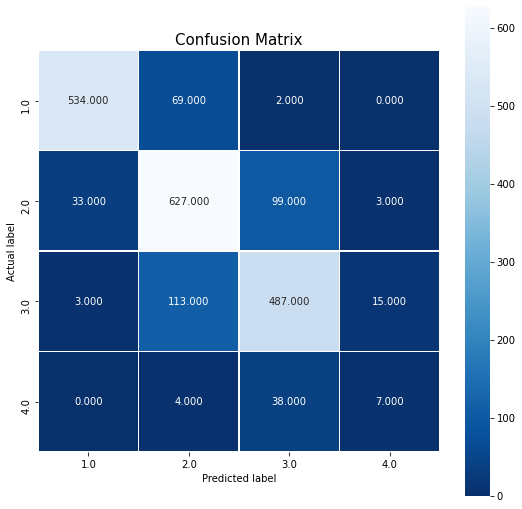

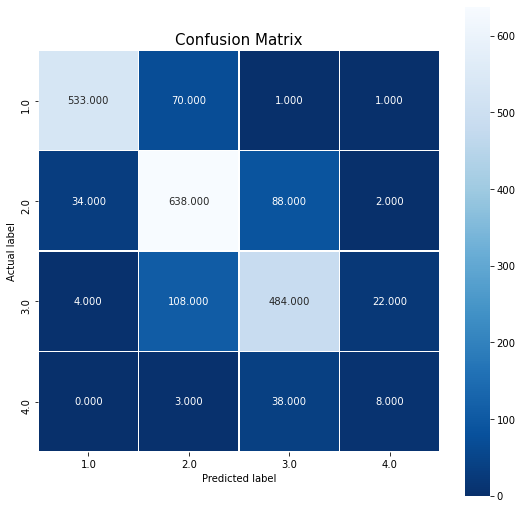

In [25]:
y_pred, y_true, clf = fit_and_predict(df, classifier=best_clfs, params=best_params_s2, PCA=PCA, drop_cat=drop_cat)
y_pred, y_true, clf = fit_and_predict(df)

## Save results to file

In [26]:
results = dict(**best_params_s1)
results['params'] = best_params_s2
print('RESULTS:')
display(results)

fname = f"./cross_validation/frank/opt_par_cv.p"
pickle.dump(results, open(fname, "wb"))

RESULTS:


{'classifier': ('xgb', 'logistic', 'tree'),
 'PCA': False,
 'drop_cat': True,
 'params': [{'scale_pos_weight': 1.0,
   'learning_rate': 0.1,
   'max_depth': 9,
   'gamma': 0.2,
   'colsample_bytree': 1.0,
   'verbosity': 0},
  {'max_iter': 1000, 'tol': 0.0001, 'class_weight': None, 'C': 2.0},
  {'class_weight': None,
   'min_samples_split': 8,
   'min_samples_leaf': 1,
   'max_depth': 6}]}